In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as date
import math
import os

In [2]:
plot2 = pd.read_csv('../data/dublin_port/data-plot-5.csv')
plot3 = pd.read_csv('../data/dublin_port/data-plot-6.csv')
plot4 = pd.read_csv('../data/dublin_port/data-plot-7.csv')

In [3]:
aqi_2022 = pd.concat([plot2,plot3,plot4], axis=0).reset_index()

In [4]:
aqi_2022 = aqi_2022.rename(columns={'Date and Time': 'datetime', 'PM<sub>10</sub>': 'pm10', 'PM<sub>2.5</sub>': 'pm2.5'})

In [5]:
aqi_2022.dtypes

index               int64
datetime           object
NO<sub>2</sub>    float64
SO<sub>2</sub>    float64
pm10              float64
pm2.5             float64
dtype: object

In [6]:
aqi_2022['datetime'] = pd.to_datetime(aqi_2022['datetime'])

In [7]:
aqi_2022.head()

,index,datetime,NO<sub>2</sub>,SO<sub>2</sub>,pm10,pm2.5
0,0,2022-01-01 00:00:00,22.00,2.12,7.31,4.08
1,1,2022-01-01 01:00:00,17.49,2.05,20.61,12.70
2,2,2022-01-01 02:00:00,13.28,2.29,30.00,16.92
3,3,2022-01-01 03:00:00,18.56,2.79,31.65,17.93
4,4,2022-01-01 04:00:00,13.83,2.07,27.55,15.19


# Handling missing values

### Visualising outliers

/var/folders/6k/3vmlhmb52cx2vjf55_z_zgg00000gn/T/ipykernel_6304/60726568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeframe.loc[:, 'month'] = timeframe['datetime'].dt.strftime('%b')


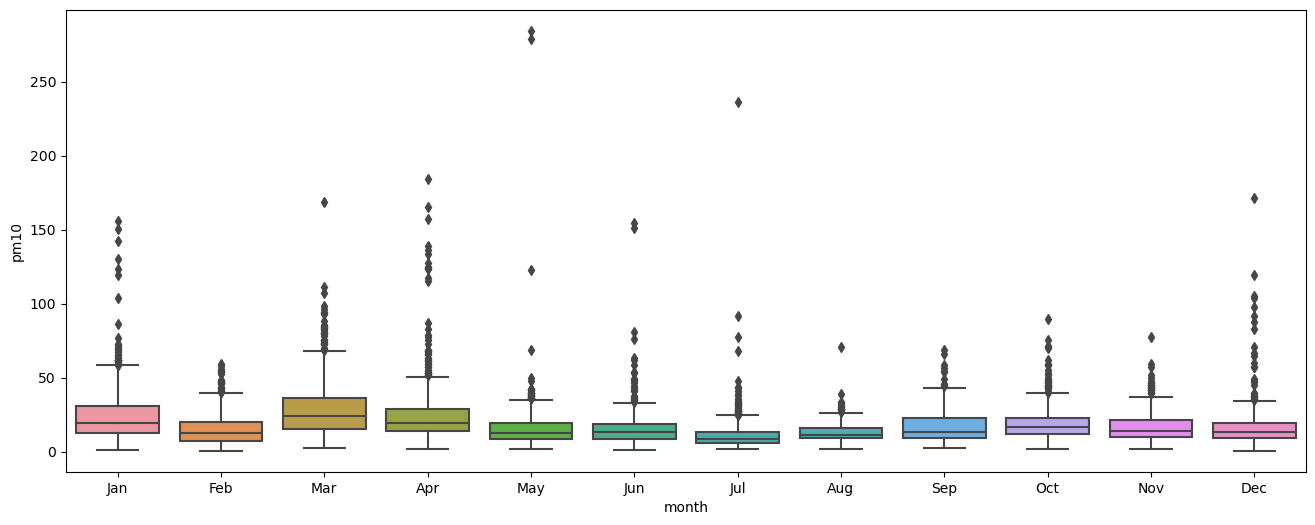

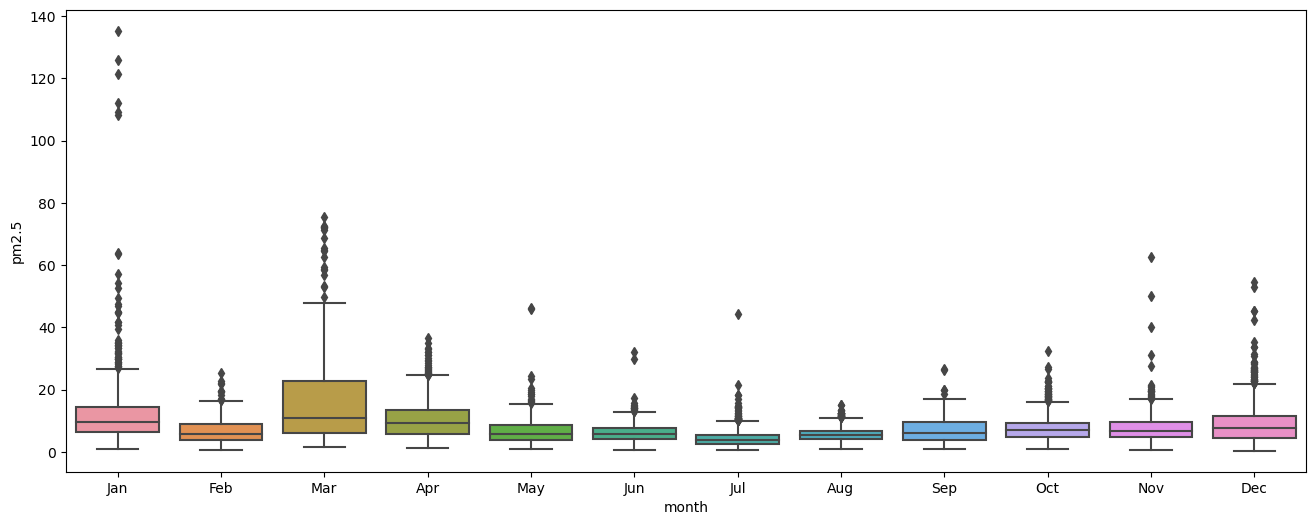

In [8]:
def plotbox(dataset,fromtime, to, title):
    timeframe = dataset[(dataset['datetime'] >= fromtime)
                         & (dataset['datetime'] <= to)]
    
    timeframe.loc[:, 'month'] = timeframe['datetime'].dt.strftime('%b')
    
    plt.figure(figsize=(16, 6))
    
    sns.boxplot(data=timeframe, x='month', y='pm10')
    
    plt.show()
    
    plt.figure(figsize=(16, 6))
    
    sns.boxplot(data=timeframe, x='month', y='pm2.5')
    
    plt.show()

plotbox(aqi_2022,'2022-01-01', '2022-12-31', 'AQI levels at Amiens street, Dublin')

    
    

In [9]:
aqi_copy = aqi_2022.copy()

In [10]:
def removeOutliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_filtered = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df_filtered

aqi_copy = removeOutliers(aqi_copy, 'pm10')
aqi_copy = removeOutliers(aqi_copy, 'pm2.5')

In [11]:
print(len(aqi_copy['pm10']))
len(aqi_2022['pm10'])

7284


8091

/var/folders/6k/3vmlhmb52cx2vjf55_z_zgg00000gn/T/ipykernel_6304/60726568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeframe.loc[:, 'month'] = timeframe['datetime'].dt.strftime('%b')


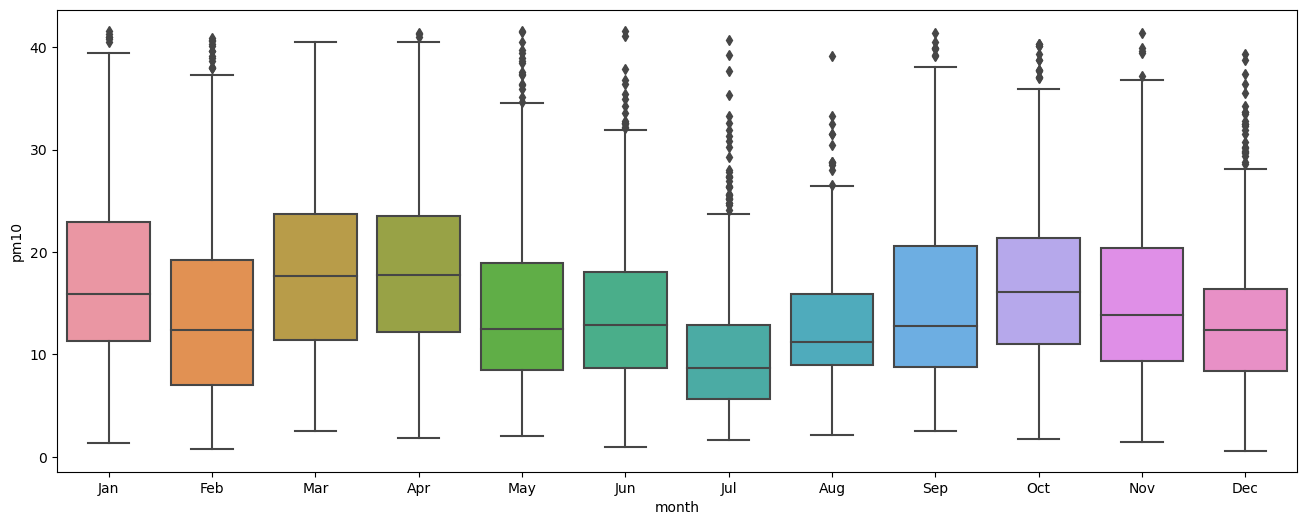

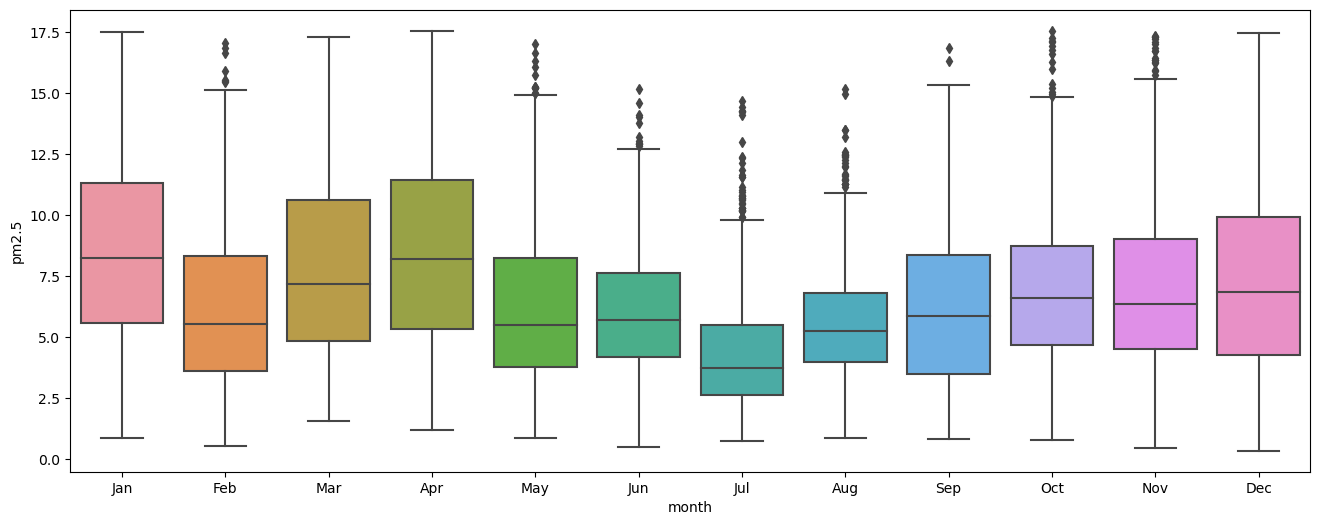

In [12]:
plotbox(aqi_copy,'2022-01-01', '2022-12-31', 'AQI levels at Amiens street, Dublin')

### Visualising distribution

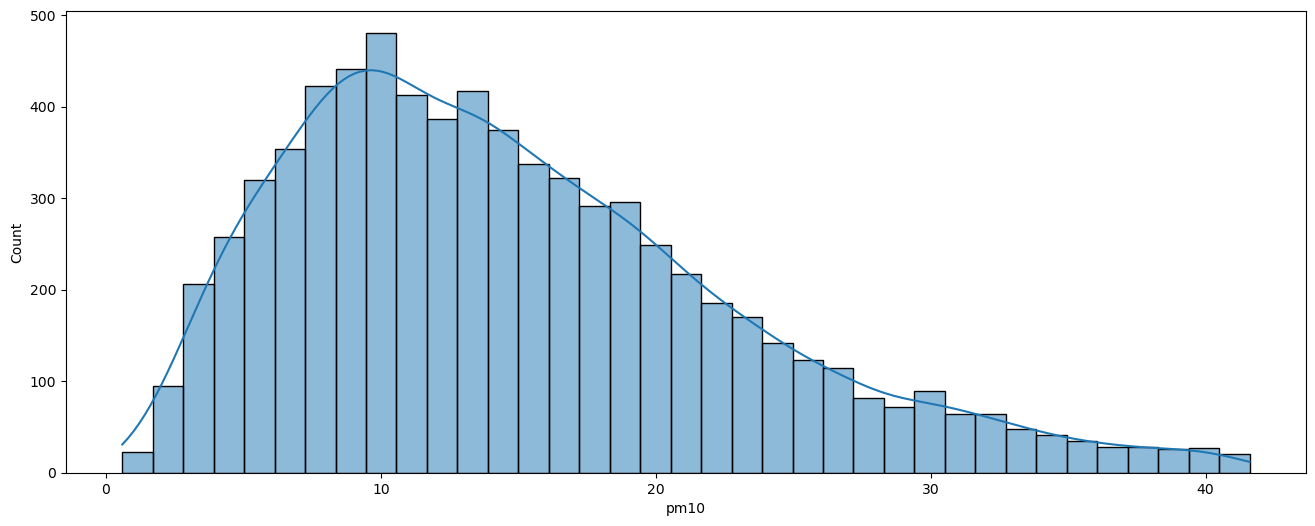

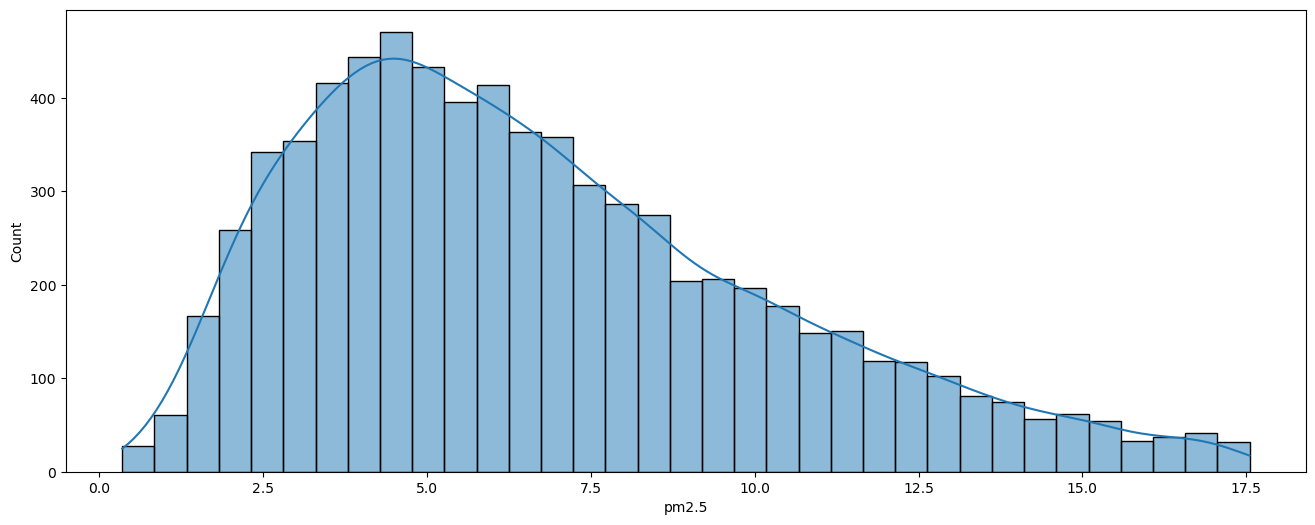

In [13]:
def plothistogram(dataset,fromtime, to, title):
    timeframe = dataset[(dataset['datetime'] >= fromtime)
                         & (dataset['datetime'] <= to)]
    
    plt.figure(figsize=(16, 6))
    
    sns.histplot(timeframe['pm10'], kde=True)
    
    plt.show()
    
    plt.figure(figsize=(16, 6))
    
    sns.histplot(timeframe['pm2.5'], kde=True)
    
    plt.show()

plothistogram(aqi_copy,'2022-01-01', '2022-12-31', 'AQI levels at Amiens street, Dublin')

    
    

### How many days of data is missing?

In [14]:
df = aqi_copy.set_index('datetime')
len(pd.date_range(start = aqi_copy['datetime'].min(), end = aqi_copy['datetime'].max()).difference(df.index))

65

In [15]:
aqi_copy = (aqi_copy.set_index('datetime')
      .reindex(pd.date_range(aqi_copy['datetime'].min(), aqi_copy['datetime'].max(), freq='1h'))
      .rename_axis(['datetime'])
      .fillna(np.nan)
      .reset_index())

### How many missing values?

In [16]:
aqi_copy.isna().sum()

datetime             0
index             1473
NO<sub>2</sub>    1495
SO<sub>2</sub>    1474
pm10              1473
pm2.5             1473
dtype: int64

In [17]:
monthly_mean = aqi_copy.set_index('datetime')
monthly_mean = monthly_mean.resample('M').mean().reset_index()
monthly_mean['month'] = monthly_mean['datetime'].dt.strftime("%m")

In [18]:
def fillMissingValues(row, df, col_name):
    datetime = row['datetime']
    row_val = row[col_name]
    if math.isnan(row_val):
        
        datarrow = df[df['month'] == datetime.strftime("%m")]
        
        [value] = datarrow[col_name].values
        row_val = value

    return row_val

aqi_copy['pm10'] = aqi_copy.apply(lambda x: fillMissingValues(x, monthly_mean, 'pm10'), axis = 1)
aqi_copy['pm2.5'] = aqi_copy.apply(lambda x: fillMissingValues(x, monthly_mean, 'pm2.5'), axis = 1)

In [19]:
aqi_copy.isna().sum()

datetime             0
index             1473
NO<sub>2</sub>    1495
SO<sub>2</sub>    1474
pm10                 0
pm2.5                0
dtype: int64

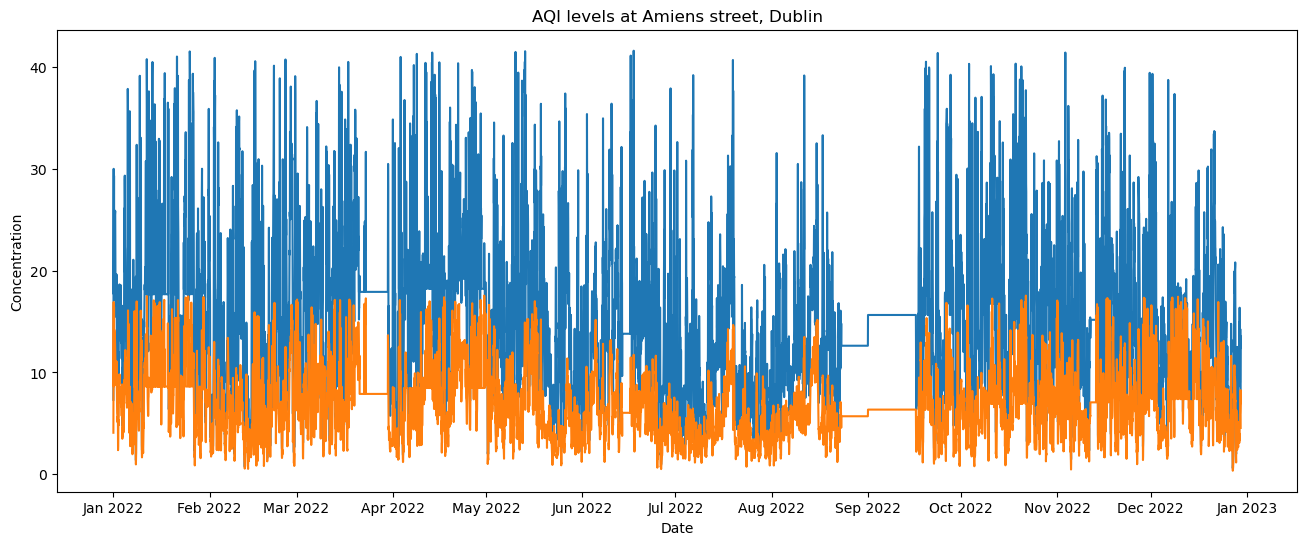

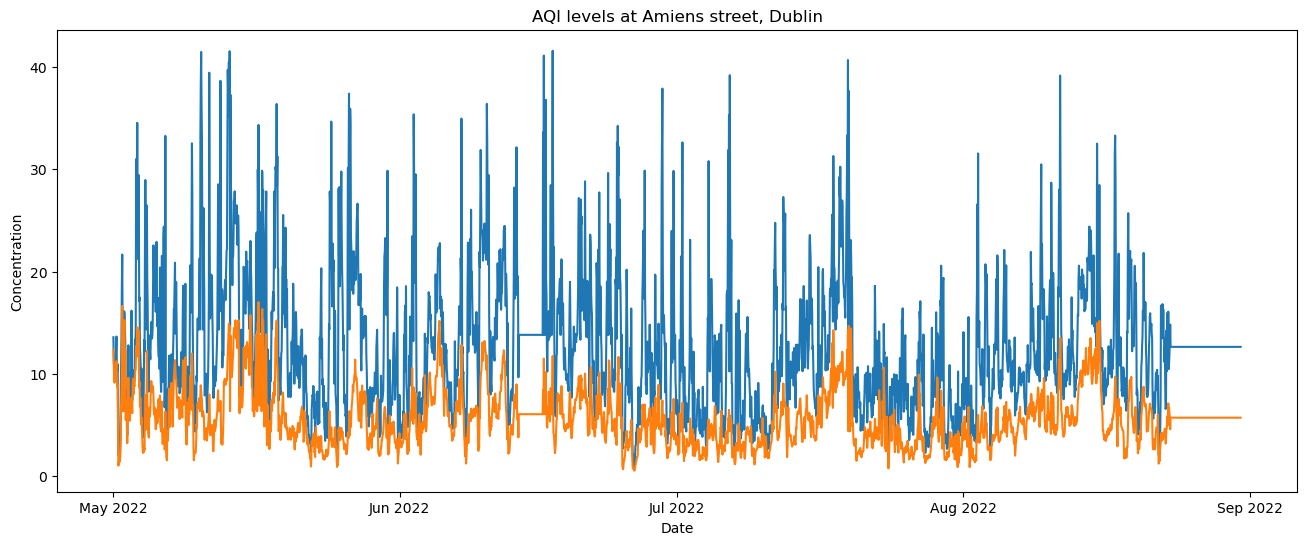

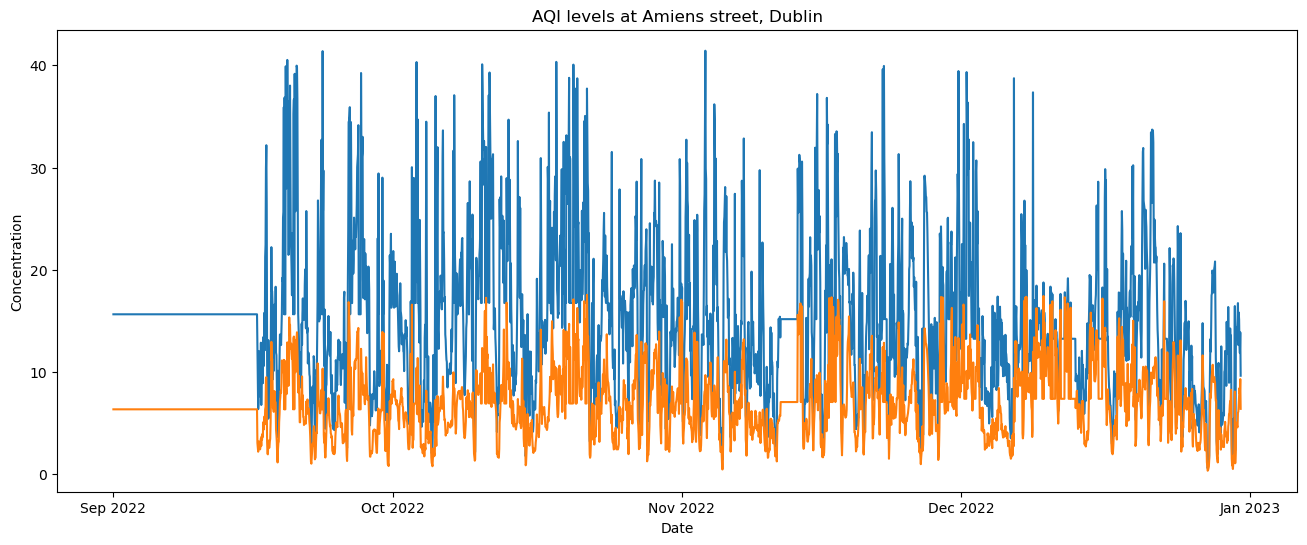

In [20]:
import matplotlib.dates as mdates

def plotline(dataset,fromtime, to, title):
    timeframe = dataset[(dataset['datetime'] >= fromtime)
                         & (dataset['datetime'] <= to)]

    plt.figure(figsize=(16, 6))
    sns.lineplot(data=timeframe, x='datetime', y='pm10')
    sns.lineplot(data=timeframe, x='datetime', y='pm2.5')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
    plt.title(title)

    date_formatter = mdates.DateFormatter('%b %Y')  # Format as abbreviated month and year (e.g., Jan 2022)
    desired_tick_frequency = mdates.MonthLocator()
    # Apply the tick frequency and formatter to the x-axis
    plt.gca().xaxis.set_major_locator(desired_tick_frequency)
    plt.gca().xaxis.set_major_formatter(date_formatter)
    
    #plt.legend()
    
    plt.show()

plotline(aqi_copy,'2022-01-01', '2022-12-30', 'AQI levels at Amiens street, Dublin')

plotline(aqi_copy,'2022-05-01', '2022-08-31', 'AQI levels at Amiens street, Dublin')

plotline(aqi_copy,'2022-09-01', '2022-12-31', 'AQI levels at Amiens street, Dublin')


/var/folders/6k/3vmlhmb52cx2vjf55_z_zgg00000gn/T/ipykernel_6304/3154161308.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeframe.loc[:, 'month'] = timeframe['datetime'].dt.strftime('%m')
/var/folders/6k/3vmlhmb52cx2vjf55_z_zgg00000gn/T/ipykernel_6304/3154161308.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeframe.loc[:, 'day'] = timeframe['datetime'].dt.strftime('%d')


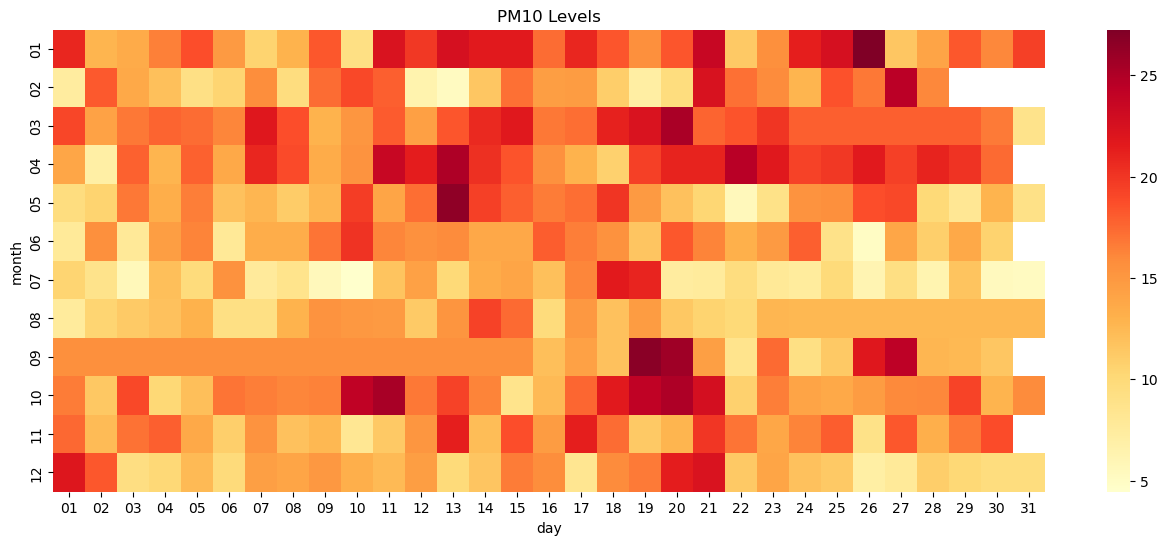

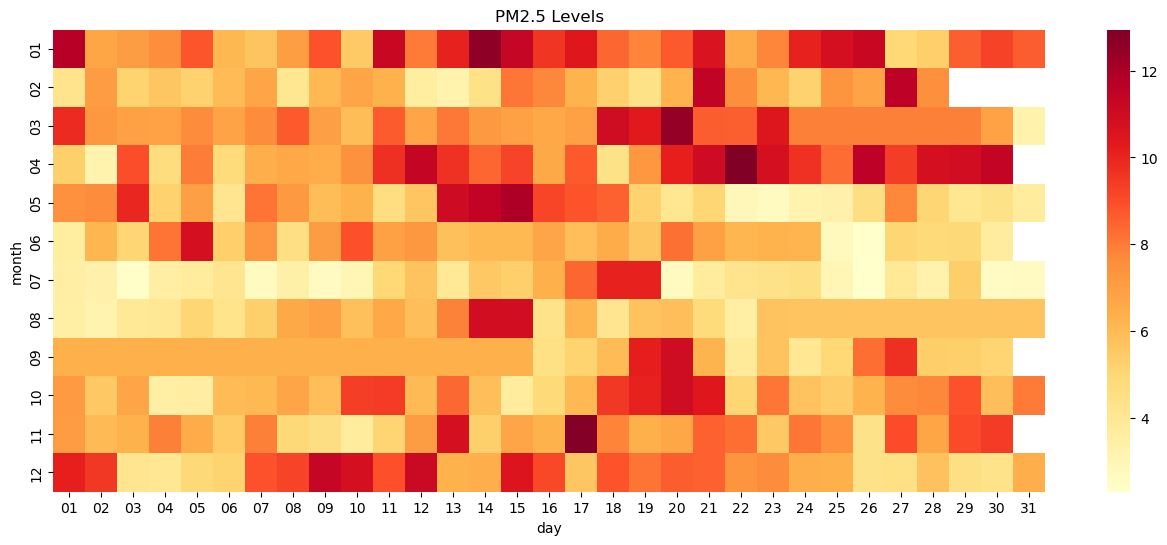

In [21]:

def plotheatmap(dataset, fromtime, to, title):
    dataset = dataset.reset_index()
    timeframe = dataset[(dataset['datetime'] >= fromtime)
                         & (dataset['datetime'] <= to)]
    
    timeframe.loc[:, 'month'] = timeframe['datetime'].dt.strftime('%m')
    timeframe.loc[:, 'day'] = timeframe['datetime'].dt.strftime('%d')
    
    timeframe_pm10 = timeframe.pivot_table(index = 'month',values='pm10', columns='day')
    #g = sns.FacetGrid(timeframe, col="month", col_wrap=2)
    
    #g.map_dataframe(lambda data, color: sns.heatmap(data=timeframe, cmap='YlOrRd'))
    plt.figure(figsize=(16, 6))
    sns.heatmap(data=timeframe_pm10, cmap='YlOrRd')
    
    plt.title("PM10 Levels")
    plt.show()
    
    timeframe_pm25 = timeframe.pivot_table(index = 'month',values='pm2.5', columns='day')
    #g = sns.FacetGrid(timeframe, col="month", col_wrap=2)
    
    #g.map_dataframe(lambda data, color: sns.heatmap(data=timeframe, cmap='YlOrRd'))
    plt.figure(figsize=(16, 6))
    sns.heatmap(data=timeframe_pm25, cmap='YlOrRd')
    
    plt.title("PM2.5 Levels")
    plt.show()

plotheatmap(aqi_copy,'2022-01-01', '2022-12-31', 'AQI levels at Amiens street, Dublin')



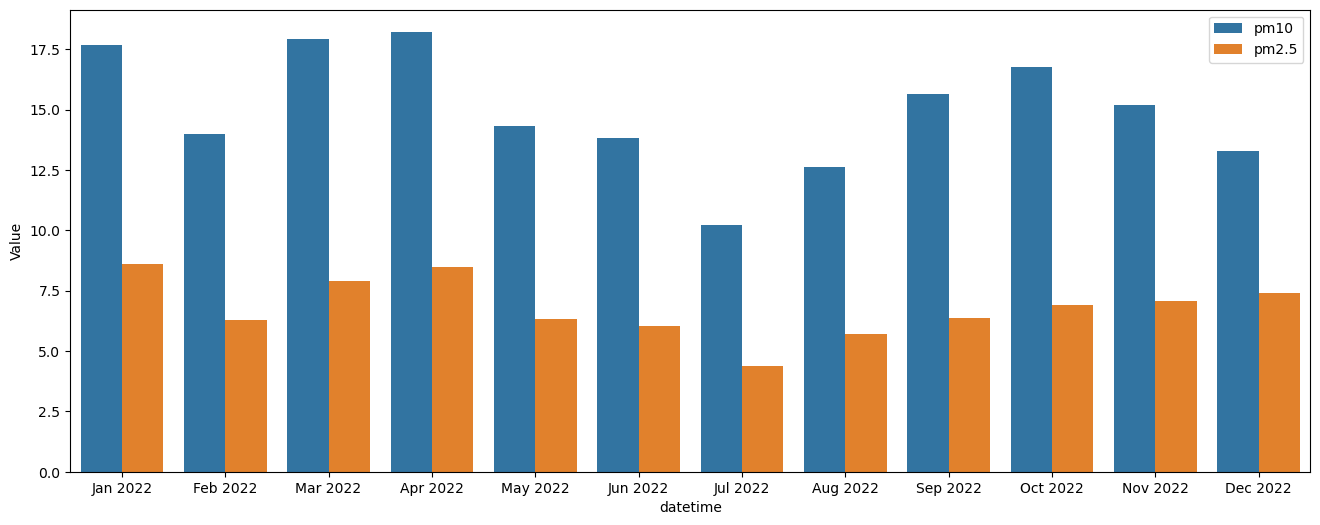

In [22]:
def plotbars(dataset, fromtime, to, title):
    timeframe = dataset[(dataset['datetime'] >= fromtime)
                         & (dataset['datetime'] <= to)]
    
    timeframe.set_index('datetime', inplace=True)
    
    timeframe = timeframe.resample('M').mean().reset_index()
    
    plt.figure(figsize=(16, 6))
    
    df_melted = pd.melt(timeframe, id_vars='datetime', value_vars=['pm10', 'pm2.5'], var_name='Pollutant', value_name='Value')

    # Create the grouped bar plot using seaborn
    sns.barplot(data=df_melted, x='datetime', y='Value', hue='Pollutant')

    plt.gca().xaxis.set_major_formatter(plt.FixedFormatter([date.strftime('%b %Y') for date in timeframe['datetime']]))

    plt.legend()
    
    plt.show()

plotbars(aqi_copy,'2022-01-01', '2022-12-31', 'AQI levels at Amiens street, Dublin')    
